In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import pandas as pd
sys.path.append("../../../..") # relative path to module toolkit

In [3]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [4]:
# setup
batch_size = 1
genus = "Philonthus"
val_dir = "../../../../../images/images_genus_species_shuffled/val/" + genus + "/"
saved_model = genus + '_resNet50pretrained_2.h5'
results_file = "results.csv"

In [5]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [6]:
model = load_model(saved_model)

In [7]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 849 images belonging to 44 classes.


In [8]:
Y_pred = model.predict_generator(val_generator, steps=val_generator.samples, verbose=1)

849/849 [==============================] - 23s 27ms/step


In [9]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [10]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split(' ')
        row_data = [data for data in row_data if data]
        if len(row_data) > 0:
            row['class'] = row_data[0] + " " + row_data[1]
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            row['support'] = float(row_data[5])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report2.csv', index = False)

In [11]:
report = classification_report(val_generator.classes, y_pred, target_names=labels)
classification_report_csv(report)
print(report)

                           precision    recall  f1-score   support

      Philonthus fumarius       0.93      0.88      0.90        16
      Philonthus addendus       0.25      0.29      0.27        17
       Philonthus albipes       0.69      0.90      0.78        30
       Philonthus alpinus       0.00      0.00      0.00         4
       Philonthus atratus       0.63      0.58      0.60        33
     Philonthus binotatus       0.14      0.25      0.18         4
   Philonthus carbonarius       0.93      0.20      0.33        71
      Philonthus cognatus       0.91      0.90      0.91        69
     Philonthus concinnus       0.00      0.00      0.00        14
      Philonthus confinis       1.00      0.33      0.50         3
     Philonthus corruscus       1.00      1.00      1.00         4
      Philonthus corvinus       0.00      0.00      0.00         7
    Philonthus cruentatus       0.31      1.00      0.47         8
       Philonthus debilis       0.56      0.47      0.51     

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[ 0.875       0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.29411765  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.9        ...,  0.          0.          0.03333333]
 ..., 
 [ 0.          0.          0.         ...,  0.51851852  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.30769231  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.81818182]]


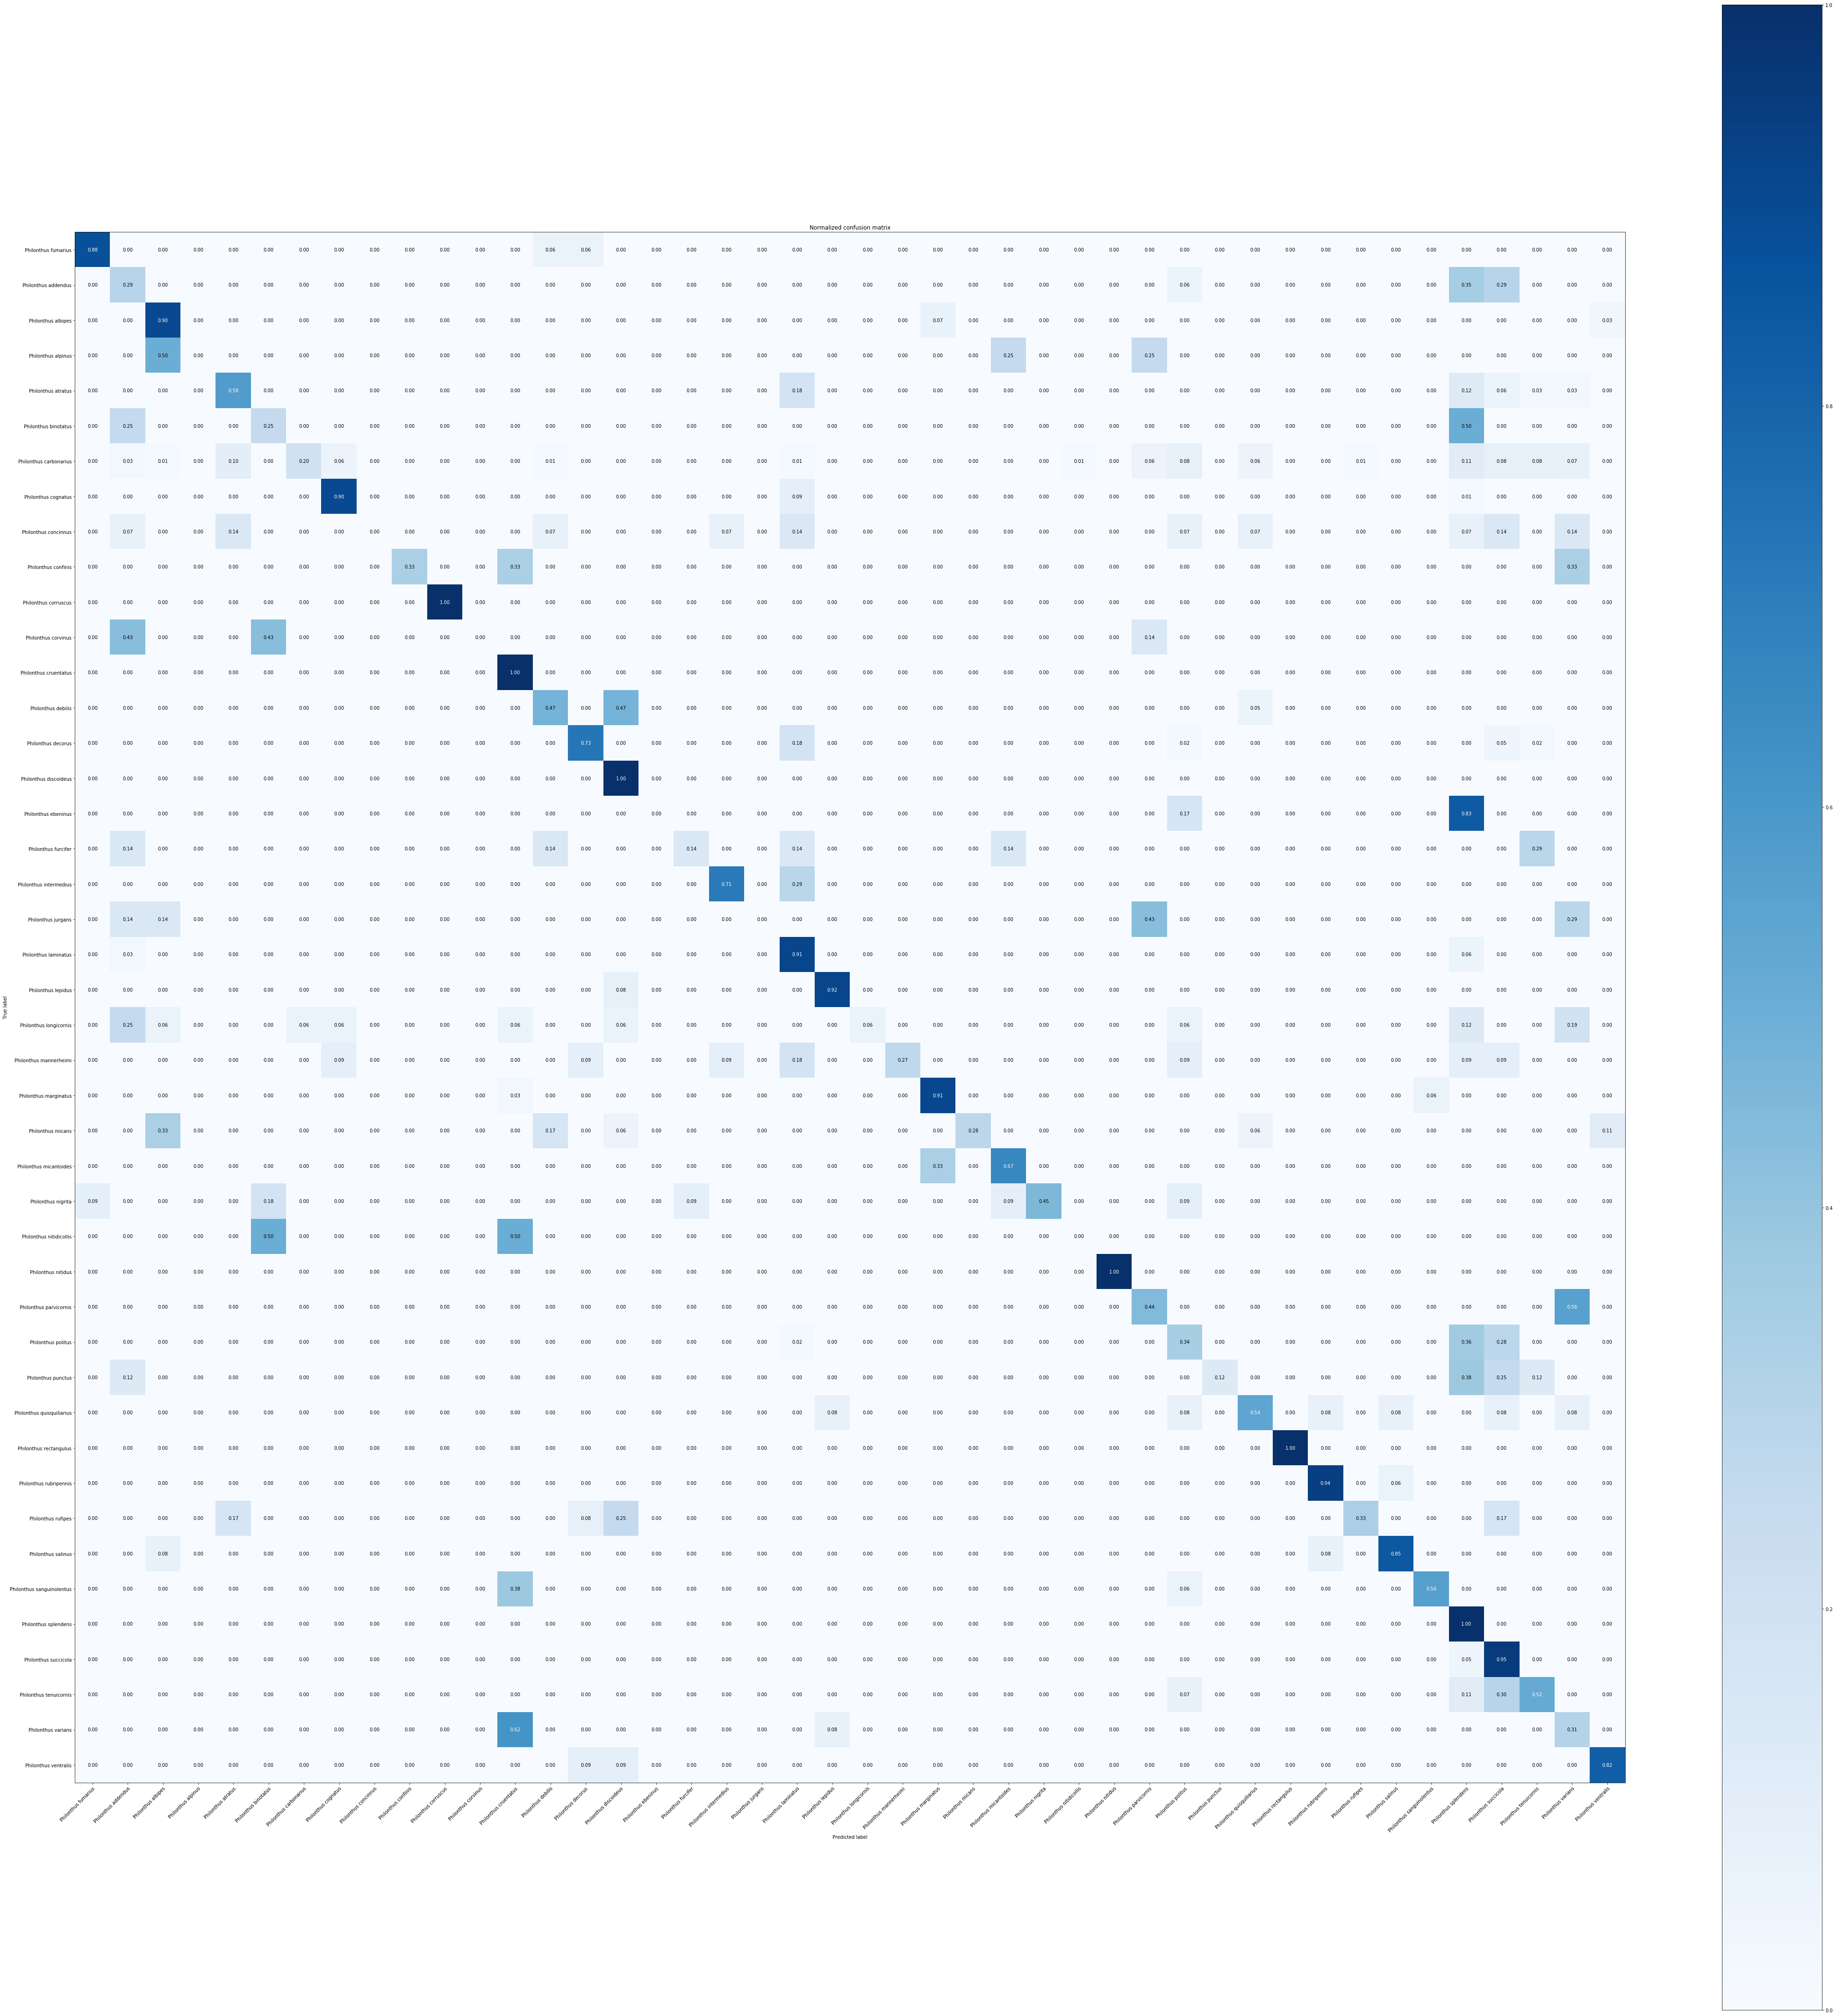

In [12]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [60, 60]
fig, ax = plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)
fig.savefig('./confusion_matrix_norm.png')

In [13]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [14]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)

NameError: name 'datasetDir' is not defined